<div width="100%">
    <img width="100%" src="https://storage.googleapis.com/kaggle-datasets-images/554905/1010567/1e68856640ce3d26d188e63950ce26ad/dataset-cover.jpg"/>
</div>

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

<h1 id="dataset" style="color:#37485a; background:#cfd1c7; border:0.5px dotted #37485a;"> 
    <center>Dataset
        <a class="anchor-link" href="#dataset" target="_self">¶</a>
    </center>
</h1>

## Load data

In [ ]:
path = '../input/brasilian-houses-to-rent/houses_to_rent_v2.csv'
df = pd.read_csv(path)
df = shuffle(df)
df.head()

## Categorical encoding

In [ ]:
unique_cities = df['city'].unique().tolist()
cities_to_idx = {v:k for k,v in enumerate(unique_cities)}
df['city'].replace(cities_to_idx, inplace=True)

unique_animal = df['animal'].unique().tolist()
animal_to_idx = {v:k for k,v in enumerate(unique_animal)}
df['animal'].replace(animal_to_idx, inplace=True)

unique_furniture = df['furniture'].unique().tolist()
furniture_to_idx = {v:k for k,v in enumerate(unique_furniture)}
df['furniture'].replace(furniture_to_idx, inplace=True)

## Split into cheap (0) and rich rentals (1)

In [ ]:
total_mean = df['total (R$)'].mean()
print(total_mean)

In [ ]:
df['total (R$)'].values[df['total (R$)'].values < total_mean] = 0
df['total (R$)'].values[df['total (R$)'].values > total_mean] = 1

## Describe each feature

In [ ]:
df.describe().T

## Standardize the features

In [ ]:
# replace floor '-' by 0 so we can convert to integer
df['floor'].replace({'-': 0}, inplace=True)

scaler_cols = df.columns.tolist()

scaler_cols.remove('animal')
scaler_cols.remove('furniture')
scaler_cols.remove('total (R$)')

In [ ]:
scaler = StandardScaler()

df[scaler_cols] = scaler.fit_transform(df[scaler_cols])
df.head()

## Features correlations

In [ ]:
corr = df.corr()

plt.figure(figsize=(14,8))

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap="Blues", annot=True)

## Features that have highest correlation with 'total (R$)'

In [ ]:
top_corr = corr['total (R$)'][corr['total (R$)'] > 0.5].index.tolist()
top_corr.remove('total (R$)')
print(top_corr)

In [ ]:
features = df[top_corr].values
labels = df['total (R$)'].values

## Split the training/testing set and create the batches

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                    features, labels, test_size=0.3, random_state=42)

In [ ]:
batch_size = 4
batches_idx = np.array_split(shuffle(np.arange(len(X_train))), len(X_train) / batch_size)

<h1 id="binary" style="color:#37485a; background:#cfd1c7; border:0.5px dotted #37485a;"> 
    <center>Binary Cross-Entropy
        <a class="anchor-link" href="#binary" target="_self">¶</a>
    </center>
</h1>

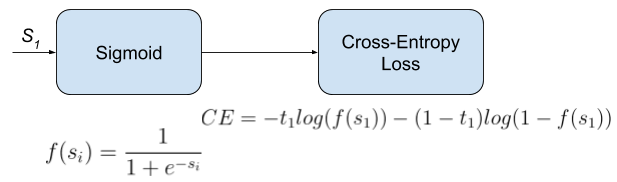

## Activation function with derivative

In [ ]:
def sigmoid(x):
    z = 1. / (1. + np.exp(-x))
    return z

def dsigmoid(x):
    z = sigmoid(x) * (1. - sigmoid(x))
    return z

## Loss function with derivative

In [ ]:
def cross_entropy(y_hat, y):
    return (-y.dot(np.log(y_hat)) - (1.-y).dot(np.log(1. - y_hat))).tolist()

def dcross_entropy(y_hat, y):
    return y_hat - y

## Hyperparameters

In [ ]:
scale = 1/max(1., (2+2)/2.)
limit = np.sqrt(3.0 * scale)

np.random.seed(123)

lr = 0.0002
nr_features = X_train.shape[1]
w = np.random.uniform(-limit, limit, size=(nr_features,1))

## Prediction function for sigmoid

In [ ]:
def predict(x):
    return 1 if x > 0.5 else 0

## Training

In [ ]:
total_mean_losses = []
total_mean_accuracies = []

for e in range(20):
    
    losses = []
    accuracies = []
    for b_idx in batches_idx:
        X = X_train[b_idx]
        y = y_train[b_idx].reshape(1, -1)

        # forward
        l1 = sigmoid(X.dot(w))
        loss = 1/len(y) * cross_entropy(l1, y)[0][0]
        losses.append(loss)
        
        preds = np.array([predict(l) for l in l1])
        accs = len(np.where(preds == y)[1]) / len(y[0])
        accuracies.append(accs)
        
        # backward
        dcross = dcross_entropy(l1, y.T)
        dw = X.T.dot(dcross * dsigmoid(l1))

        w -= lr * dw
    
    if((e+1) % 2 == 0):
        mean_losses = sum(losses) / len(losses)
        total_mean_losses.append(mean_losses)
        
        mean_accuracies = sum(accuracies) / len(accuracies)
        total_mean_accuracies.append(mean_accuracies)
        
        print("Epoch:%3d, Loss:%1.3f, Accuracy:%1.3f" % (e+1, mean_losses, mean_accuracies))

## Results

In [ ]:
plt.figure(figsize=(14,8))
plt.title("Mean Total Losses")
plt.plot(total_mean_losses)
plt.show()

In [ ]:
plt.figure(figsize=(14,8))
plt.title("Mean Total Accuracies")
plt.plot(total_mean_accuracies)
plt.show()

<h1 id="categorical" style="color:#37485a; background:#cfd1c7; border:0.5px dotted #37485a;"> 
    <center>Categorial Cross-Entropy
        <a class="anchor-link" href="#categorical" target="_self">¶</a>
    </center>
</h1>

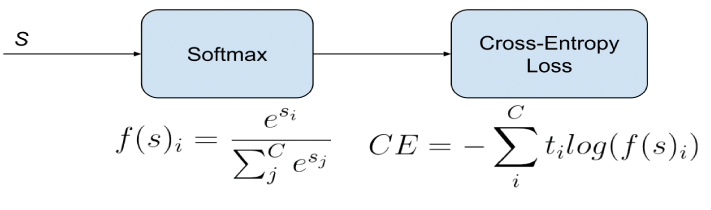

## Softmax activation function

In [ ]:
def softmax(z):
    exps = np.exp(z - np.max(z))
    return exps / np.sum(exps, axis=1, keepdims=True)

## Categorical cross-entropy and derivative

In [ ]:
def cross_entropy(y_hat, y):
    return -y.T * (np.log(y_hat.T))

def dcross_entropy(y_hat, y):
    return y_hat - y

## One hot encoding for labels

In [ ]:
# one hot encoding
y_train = np.eye(2)[y_train]
print(y_train[0])

## Hyperparameters

In [ ]:
scale = 1/max(1., (2+2)/2.)
limit = np.sqrt(3.0 * scale)

w1 = np.random.uniform(-limit, limit, size=(nr_features, 8))
w2 = np.random.uniform(-limit, limit, size=(8, 2))

## Training

In [ ]:
total_mean_losses = []
total_mean_accuracies = []

for e in range(100):
    
    losses = []
    accuracies = []
    for b_idx in batches_idx:
        X = X_train[b_idx]
        y = y_train[b_idx]

        # forward
        l1 = sigmoid(X.dot(w1))
        l2 = softmax(l1.dot(w2))
        loss = 1/len(y) * cross_entropy(l2, y)
        losses.append(loss.mean())
        
        preds = np.array([np.argmax(l) for l in l2])
        accs = len(np.where(preds == np.argmax(y, axis=1))[0]) / len(y)
        accuracies.append(accs)
        
        # backward
        dl2 = dcross_entropy(l2, y)
        dl1 = dsigmoid(l1) * (dl2).dot(w2.T)
        
        dw2 = l1.T.dot(dl2)
        dw1 = X.T.dot(dl1)

        w2 -= lr * dw2
        w1 -= lr * dw1
    
    if((e+1) % 10 == 0):
        mean_losses = sum(losses) / len(losses)
        total_mean_losses.append(mean_losses)
        
        mean_accuracies = sum(accuracies) / len(accuracies)
        total_mean_accuracies.append(mean_accuracies)
        
        print("Epoch:%3d, Loss:%1.3f, Accuracy:%1.3f" % (e+1, mean_losses, mean_accuracies))

## Results

In [ ]:
plt.figure(figsize=(14,8))
plt.title("Mean Total Losses")
plt.plot(total_mean_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
plt.figure(figsize=(14,8))
plt.title("Mean Total Accuracies")
plt.plot(total_mean_accuracies)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()